# Recurrent Neural Network (RNN)
****

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## I. Vanilla RNN

<div align="center">
    <img src="./attachments/ArchComponent.png" width="800"/>
</div>

### 1. Build RNN Cell
Implements the computation for a single time step.
- $a^{<t>} = f(W_{aa} \cdot a^{<t-1>} + W_{ax} \cdot x^{<t>} + b_a)$

In [39]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, activation_fn = "tanh"):
        super(RNNCell, self).__init__()
        self.input_size  = input_size  #Vocab size
        self.hidden_size = hidden_size
        
        #W_ax*x^<t>  : input-to-hidden weights
        self.linear_ax = nn.Linear(input_size, hidden_size)
        #W_aa*a^<t-1>: statestate-to-hidden weights
        self.linear_aa = nn.Linear(hidden_size, hidden_size, bias = True) #Include bias b_a
        
        #Activation function
        if activation_fn.lower() == "tanh":
            self.activation = nn.Tanh()
        elif activation_fn.lower() == "relu":
            self.activation = nn.ReLU()
        else:
            raise ValueError("Unsupported Activation Function")
        
    def forward(self, x, a_prev):
        #x     : input at t (batch_size, input_size)
        #a_prev: previous state (batch_size, hidden_size)
        input_transformed  = self.linear_ax(x)
        hidden_transformed = self.linear_aa(a_prev)
        z = input_transformed + hidden_transformed
        a = self.activation(z) #a^t
        return a

## 2. Build VanillaRNN (RNN through many time steps)

In [50]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn = "tanh", output_activation_fn = "softmax"):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size #y^t

        #Init RNN Cell
        self.rnn_cell = RNNCell(input_size, hidden_size, activation_fn)

        #W_ya: hidden-to-output weight
        self.linear_ya = nn.Linear(hidden_size, output_size) #Included b_y

        #Output Activation Function
        if output_activation_fn.lower() == "softmax":
            self.output_activation = nn.Softmax(dim = -1)  #Multi-class
        elif output_activation_fn.lower() == "sigmoid":
            self.output_activation = nn.Sigmoid()          #Binary-class
        elif output_activation_fn.lower() == "none":
            self.output_activation = None                  #No Activation function (Recursive)
        else:
            print(f"Warning: output_activation_fn '{output_activation_fn}' not explicitly handled for output_size {output_size}. No output activation will be used.")
            self.output_activation = None
    
    #Forward pass: whole sequences
    def forward(self, sequence, a_0 = None):
        batch_size, sequence_length, _ = sequence.shape

        #Init first hidden state
        if a_0 is None:
            a_prev = torch.zeros(batch_size, self.hidden_size, device = sequence.device)
        else:
            a_prev = a_0

        #Save output & hidden states each time step
        output_list = []
        states_list = []

        #Loop through time steps
        for t in range(sequence_length):
            x_t = sequence[:, t, :]             # Input at t
            a_t = self.rnn_cell(x_t, a_prev)    # Next hidden state / hidden state at t
            
            #Predict output y_hat^t
            z_t = self.linear_ya(a_t)
            #Activation
            if self.output_activation is not None:
                y_hat = self.output_activation(z_t)
            else:
                y_hat = z_t
            
            #Saving result
            output_list.append(y_hat)
            states_list.append(a_t)

            #Update a_prev
            a_prev = a_t

        #Stacking tensor
        hiddens = torch.stack(states_list, dim = 1)
        outputs = torch.stack(output_list, dim = 1)

        return hiddens, outputs

## 3. Demo

### 3.1 Data Preparation

In [66]:
test_text = "Reuters is a news agency owned by Thomson Reuters. It employs around 2,500 journalists and 600 photojournalists in about 200 locations worldwide writing in 16 languages. Reuters is one of the largest news agencies in the world. The agency was established in London in 1851 by Paul Reuter."

chars = sorted(list(set(test_text)))
char_int_map = {char: i for i, char in enumerate(chars)}
int_char_map = {i: char for i, char in enumerate(chars)}

vocab_size = len(chars) # Vocabulary size (number of unique characters)
print(f"Original text: '{test_text}'")
print(f"Unique characters (vocabulary): {chars}")
print(f"Character to integer mapping: {char_int_map}")
print(f"Vocabulary size: {vocab_size}")

Original text: 'Reuters is a news agency owned by Thomson Reuters. It employs around 2,500 journalists and 600 photojournalists in about 200 locations worldwide writing in 16 languages. Reuters is one of the largest news agencies in the world. The agency was established in London in 1851 by Paul Reuter.'
Unique characters (vocabulary): [' ', ',', '.', '0', '1', '2', '5', '6', '8', 'I', 'L', 'P', 'R', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'w', 'y']
Character to integer mapping: {' ': 0, ',': 1, '.': 2, '0': 3, '1': 4, '2': 5, '5': 6, '6': 7, '8': 8, 'I': 9, 'L': 10, 'P': 11, 'R': 12, 'T': 13, 'a': 14, 'b': 15, 'c': 16, 'd': 17, 'e': 18, 'f': 19, 'g': 20, 'h': 21, 'i': 22, 'j': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'w': 33, 'y': 34}
Vocabulary size: 35


In [52]:
input_sequence  = []
target_sequence = []

for i in range(len(test_text) - 1):
    input_sequence.append(test_text[i])
    target_sequence.append(test_text[i+1])

input_sequence_int  = [char_int_map[char] for char in input_sequence]
target_sequence_int = [char_int_map[char] for char in target_sequence]

print("By characters, input sequence: ", input_sequence)
print("By characters, target sequence: ", target_sequence) 

By characters, input sequence:  ['H', 'e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l']
By characters, target sequence:  ['e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l', 'd']


In [53]:
def onehot_encode(sequence, vocab_size):
    encoded = np.zeros((len(sequence), vocab_size), dtype = np.float32)
    for i, value in enumerate(sequence):
        encoded[i, value] = 1
    return encoded

In [54]:
input_sequence_onehot = onehot_encode(input_sequence_int, vocab_size)
print("Shape of one hot input:", input_sequence_onehot.shape)

Shape of one hot input: (10, 8)


In [55]:
X_train  = torch.tensor(input_sequence_onehot).unsqueeze(0) # Add batch_size dimension, batch_size = 1
y_target = torch.tensor(target_sequence_int).unsqueeze(0)

print("\nX_train tensor:\n", X_train)
print("Shape of X_train:", X_train.shape) # torch.Size([1, 4, 4])
print("\ny_target tensor:\n", y_target)
print("Shape of y_target:", y_target.shape) # torch.Size([1, 4])


X_train tensor:
 tensor([[[0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0.]]])
Shape of X_train: torch.Size([1, 10, 8])

y_target tensor:
 tensor([[4, 5, 5, 6, 0, 2, 6, 7, 5, 3]])
Shape of y_target: torch.Size([1, 10])


## 3.2 Model Initilize

In [56]:
input_dim = vocab_size
hidden_dim = 16         #Size ~ Learning Better
output_dim = vocab_size

In [57]:
model = VanillaRNN(input_size    = input_dim,
                   hidden_size   = hidden_dim,
                   output_size   = output_dim,
                   activation_fn = "tanh",
                   output_activation_fn = "none")

print("RNN Model:")
print(model)

RNN Model:
VanillaRNN(
  (rnn_cell): RNNCell(
    (linear_ax): Linear(in_features=8, out_features=16, bias=True)
    (linear_aa): Linear(in_features=16, out_features=16, bias=True)
    (activation): Tanh()
  )
  (linear_ya): Linear(in_features=16, out_features=8, bias=True)
)


### 3.3 Train

In [58]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

print("\n--- Training Information ---")
print("Criterion: ", criterion)
print("Optimizer: ", optimizer)


--- Training Information ---
Criterion:  CrossEntropyLoss()
Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)



--- TRAINING ---
Epoch [50/500], Loss: 0.0717
Epoch [100/500], Loss: 0.0130
Epoch [150/500], Loss: 0.0070
Epoch [200/500], Loss: 0.0046
Epoch [250/500], Loss: 0.0033
Epoch [300/500], Loss: 0.0025
Epoch [350/500], Loss: 0.0020
Epoch [400/500], Loss: 0.0016
Epoch [450/500], Loss: 0.0013
Epoch [500/500], Loss: 0.0011
--- COMPLETE ---


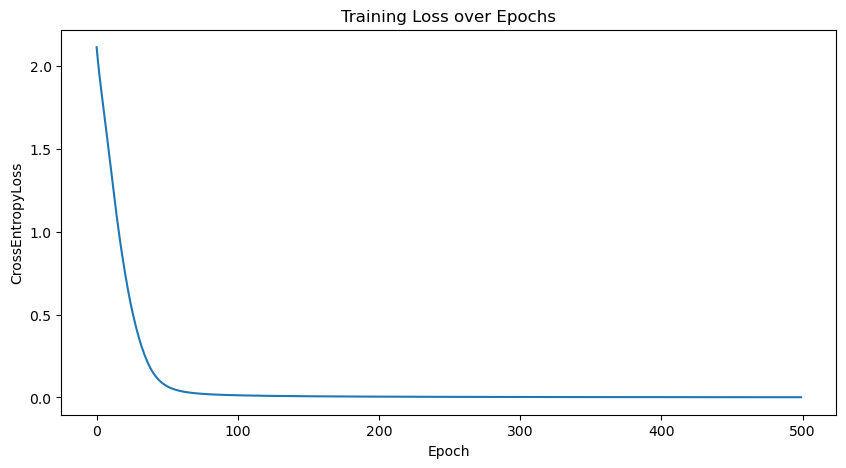

In [60]:
num_epochs = 500
losses     = []

print("\n--- TRAINING ---")
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    _, y_hat_logits_sequence = model(X_train) # Shape: (batch_size, sequence_length, vocab_size)

    # Chuẩn bị đầu ra model và target cho CrossEntropyLoss
    # Đầu ra model cần có shape (N, C) hoặc (N, C, d1, d2, ...)
    # Target cần có shape (N) hoặc (N, d1, d2, ...)
    # N ở đây là tổng số điểm dữ liệu để tính loss, C là số lớp.
    # Ta sẽ coi mỗi ký tự trong chuỗi là một điểm dữ liệu riêng.
    # Reshape y_hat_logits_sequence từ (batch, seq, classes) -> (batch*seq, classes)
    # Reshape y_target từ (batch, seq) -> (batch*seq)
    loss = criterion(y_hat_logits_sequence.view(-1, vocab_size), y_target.view(-1))

    # Backward pass (BPTT)
    loss.backward()

    # Update Weights
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("--- COMPLETE ---")

# Loss
plt.figure(figsize = (10,5))
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropyLoss")
plt.show()

### 3.4 Eval

In [64]:
# --- Kiểm tra kết quả sau huấn luyện và dự đoán ---
model.eval() # Chuyển mô hình sang chế độ đánh giá (quan trọng nếu có Dropout, BatchNorm)
with torch.no_grad(): # Không cần tính gradient khi dự đoán
    _, y_predicted_logits_sequence = model(X_train) # Shape: (batch_size, sequence_length, vocab_size)

    # Lấy xác suất bằng cách áp dụng softmax (chỉ để hiển thị, không cần cho CrossEntropyLoss)
    y_predicted_probs_sequence = torch.softmax(y_predicted_logits_sequence, dim=2)
    # Lấy ký tự dự đoán bằng cách chọn index có xác suất cao nhất
    _, predicted_indices_sequence = torch.max(y_predicted_probs_sequence, dim=2) # Shape: (batch_size, sequence_length)

    # Chuyển đổi indices dự đoán về lại ký tự
    predicted_chars_sequence = []
    for batch_idx in range(predicted_indices_sequence.shape[0]): # Lặp qua batch (chỉ có 1 batch ở đây)
        batch_chars = [int_char_map[idx.item()] for idx in predicted_indices_sequence[batch_idx]]
        predicted_chars_sequence.append(batch_chars)


    print("\n--- Kết quả Sau Huấn luyện ---")
    print(f"Đầu vào (ký tự):          {input_sequence}")
    print(f"Mục tiêu (ký tự tiếp theo): {target_sequence}")
    print(f"Dự đoán (ký tự tiếp theo): {predicted_chars_sequence[0]}") # Lấy batch đầu tiên

    # --- Thử dự đoán một chuỗi mới hoặc sinh văn bản từng ký tự ---
    print("\n--- Thử sinh văn bản từ một ký tự đầu vào ---")
    start_char = "H"
    num_to_generate = len(test_text) -1 # Sinh ra đủ số ký tự như mục tiêu
    generated_text = start_char

    current_input_char = start_char
    # Khởi tạo trạng thái ẩn ban đầu cho việc sinh văn bản
    a_prev_generate = torch.zeros(1, hidden_dim, device=X_train.device) # batch_size = 1

    for _ in range(num_to_generate):
        # Chuẩn bị đầu vào hiện tại
        current_input_int = char_int_map[current_input_char]
        current_input_one_hot = onehot_encode([current_input_int], vocab_size)
        x_t_generate = torch.tensor(current_input_one_hot).unsqueeze(0).to(X_train.device) # (1, 1, vocab_size)

        # Chỉ cần forward 1 bước thời gian để lấy trạng thái ẩn tiếp theo và dự đoán
        # Ta cần viết lại logic forward cho từng bước một nếu muốn hiệu quả
        # Hoặc, ta có thể dùng lại model.rnn_cell và model.W_ya trực tiếp
        a_next_generate = model.rnn_cell(x_t_generate.squeeze(1), a_prev_generate) # x_t (batch, input), a_prev (batch, hidden)
        logits_next_char = model.linear_ya(a_next_generate) # (batch, output_size)
        # Lấy ký tự dự đoán
        probs_next_char = torch.softmax(logits_next_char, dim=1)
        _, predicted_index = torch.max(probs_next_char, dim=1)
        predicted_char = int_char_map[predicted_index.item()]

        generated_text += predicted_char
        current_input_char = predicted_char # Ký tự dự đoán trở thành đầu vào cho bước tiếp theo
        a_prev_generate = a_next_generate # Cập nhật trạng thái ẩn

    print(f"Ký tự bắt đầu: '{start_char}'")
    print(f"Văn bản được sinh ra: '{generated_text}'")
    if generated_text == test_text:
        print("Tuyệt vời! Mô hình đã học được chuỗi một cách chính xác.")
    else:
        print("Mô hình chưa học hoàn hảo, hãy thử tăng số epoch hoặc điều chỉnh hidden_dim.")


--- Kết quả Sau Huấn luyện ---
Đầu vào (ký tự):          ['H', 'e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l']
Mục tiêu (ký tự tiếp theo): ['e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l', 'd']
Dự đoán (ký tự tiếp theo): ['e', 'l', 'l', 'o', ' ', 'W', 'o', 'r', 'l', 'd']

--- Thử sinh văn bản từ một ký tự đầu vào ---
Ký tự bắt đầu: 'H'
Văn bản được sinh ra: 'Hello World'
Tuyệt vời! Mô hình đã học được chuỗi một cách chính xác.
